## **PROJECT-5. Поведенческая аналитика (проведение ad-hoc исследования)**
<font size="5" color="red"><b>DAPR-1016</b> Pidenko Dmitry</font>

 ЛЕГЕНДА

       Продолжаем работать продуктовым аналитиком в компании-сервисе по доставке продуктов на дом. Сервис доступен как в приложении на iOS, так и на Android. Мы настроил фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил нас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. Мы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020 — только по пользователям, зарегистрированным позднее 1 января 2020.




 <font size="5" color="red"><b>**ЦЕЛЬ:**</font>

Проанализировать поведение пользователь

<font size="5" color="red"><b>**ЗАДАЧИ**</font>


1.Обработаем и проанализируем данные с помощью Python и ответим на вопросы ниже

2.Проведем когортный анализ по:

- неделе первого посещения;
- неделе регистрации;
- неделе первой покупки.

<font size="5" color="red"><b>**ОПИСАНИЕ ДАННЫХ**</font>

*→ date* — дата совершения события

*→ event* — событие

*app_install* — установка приложения

*app_start* —  открыть приложения

*registration* — зарегистрироваться 

*search* — перейти на страницу поиска товаров (каталог)

*open_item* — открыть товар

*choose_item* — отправить товар в корзину

*tap_basket* — перейти в корзину

*purchase* — подтверждение покупки

*→ gender* — пол пользователя

*→ os_name* —  платформа пользователя

*→ city* —  город пользователя

*→ device_id* — идентификатор устройства пользователя

*→ utm_source* — канал, с которого пришел пользователь

*yandex-direct* — Яндекс.Директ

*google_ads* — реклама в Google

*vk_ads* — реклама в ВК

*instagram_ads* — реклама в Инстаграм*

*facebook_ads* — реклама в Фейсбук

*referral* — акция «приведи друга»

Если стоит - (прочерк), то канал не определен или это скачивание приложения напрямую или посещение не с рекламы 
 
*→ purchase_sum* —  стоимость покупки (при совершении события *‘purchase’*)

<font size="5" color="red"><b>**Обрабатываем и ананализируем данные с помощью Python и ответим на вопросы ниже**</font>

<font size="5" color="yellow"><b>**1.Выгружаем библиотеки с которыми будем работать**</font>

In [121]:
#Выгружаем используемые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<font size="5" color="yellow"><b>**1.1.Импортируем датафрейм**</font>

In [67]:
#Выгружем таблицу с данными:
dt = pd.read_csv('IDE/data/SF_case_data.csv', sep=',')

In [68]:
#Создаем копию таблицы если вдруг что то пойдет не так:
dt1 = dt.copy()

In [69]:
#Выводим 5 строк, чтобы убедиться, что таблица импортирована:
dt1.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


<font size="5" color="yellow"><b>**1.1.1.Построим график с динамикой по всем событиям по дням**</font>

In [70]:
#Для того чтобы построить график, необходимо пересобрать таблицу:
#Сгрупперуем количество событий по каждому дню: 
dt2 = dt1.groupby('date')['event'].count().reset_index()
print(dt2.sort_values(by='event', ascending=False).head())

          date  event
9   2020-01-10  89831
65  2020-03-06  63264
10  2020-01-11  58169
44  2020-02-14  54233
13  2020-01-14  53783


Визуализирум

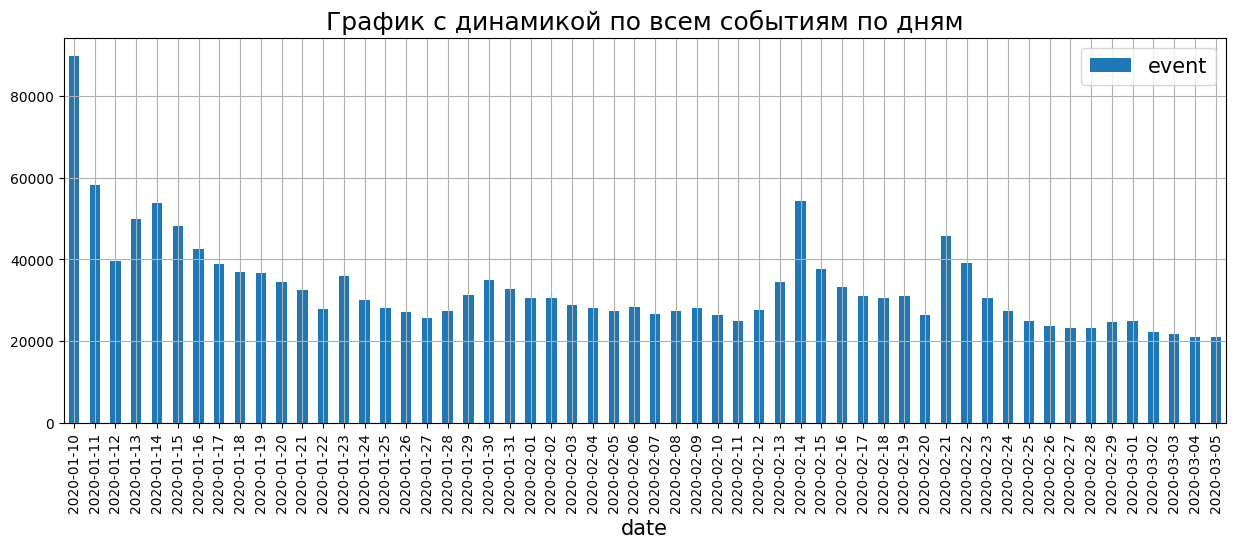

In [71]:
dt2 = dt2.iloc[9:65]
plt.rcParams['font.size'] = '15'
dt2.plot(
    kind='bar',
    grid=True,
    figsize=(15, 5),
    x='date',
    y='event',
    rot=90,
    fontsize=10,
    title='График с динамикой по всем событиям по дням'

 )
plt.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

На графике нагладно видно, что 10-ого января (2020-01-10) было больше всех событий

<font size="5" color="yellow"><b>**1.1.2.Посмотрим на то, как распределен трафик. Построим график с динамикой открытий приложений для групп «Установили в тот же день» и «Остальные».**</font>

1.Найдем сколько людей установили приложение 31 марта

In [72]:
#Для начала  находим дату, когда были установлены приложения:
installs = dt1[dt1['event'] == 'app_install']
dt1['install_date'] = dt1['device_id'].map(installs.set_index('device_id')['date'])

In [73]:
#После этого напишем функцию, которая покажет, какие пользователи «Установили в тот же день» и применяем ее к нашему датафрейму:
def new_column(date1,date2,value):
    if date1 == date2:
        return value
dt1['install_group'] = dt1.apply(lambda x: new_column(date1 = x['date'], date2 = x['install_date'], value = 'Установили в этот же день'), axis=1)

In [74]:
#Далее заполняем пропуски в колонке ‘install_group’ и заменяем их на ‘Остальные’:
dt1['install_group'] = dt1['install_group'].fillna('Остальные')

In [75]:
#После чего мы создаем новый датафрейм, чтобы отобразить динамику по дням:
dt3 = dt1[dt1['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users')

In [76]:
#Отобразим 5 строк и посмотрим, что получилось:
dt3.head(5)

,date,install_group,users
0,2020-01-01,Остальные,866
1,2020-01-01,Установили в этот же день,3579
2,2020-01-02,Остальные,1957
3,2020-01-02,Установили в этот же день,3144
4,2020-01-03,Остальные,2742


In [77]:
#Найдем сколько людей установили приложение 31 марта:
installed = dt3[dt3['date'] == '2020-03-31']
installed[installed['install_group'] == 'Установили в этот же день']

,date,install_group,users
181,2020-03-31,Установили в этот же день,968


2.Найдем долю открытий приложения 14 февраля которая пришлась на пользователей, у которых приложение уже было установлено

In [78]:
#Воспользуемся начальным датафреймом dt1 и выделиv оттуда пользователей, которые открыли приложение:
traffic=dt1[dt1['event']=='app_start']

In [79]:
#Потом мы создаем два новых датафрейма, где считаем количество инсталлов/установок (app_install) и количество открытий по дням:
same_day= installs.groupby(['date'])['device_id'].count().reset_index()
total= traffic.groupby(['date'])['device_id'].count().reset_index()

In [80]:
#Далее мы соединяем оба датафрейма в один и переименовываем столбцы:
app_open_perc=same_day.merge(total,how='left',on='date')
app_open_perc.rename(columns={'device_id_x':'same_day', 'device_id_y': 'total'},inplace=True)

In [81]:
#Затем мы вычитаем из общего количества количество тех, кто установил в тот же день:
app_open_perc['other']=app_open_perc['total']-app_open_perc['same_day']

In [82]:
#Находим долю открытий приложений:
app_open_perc['percent']=round(app_open_perc['other']/app_open_perc['total']*100)

In [83]:
#Отобразим 5 строк и посмотрим, что получилось:
app_open_perc.head()

,date,same_day,total,other,percent
0,2020-01-01,3579,4445,866,19.0
1,2020-01-02,3144,5101,1957,38.0
2,2020-01-03,2402,5144,2742,53.0
3,2020-01-04,1831,4924,3093,63.0
4,2020-01-05,1671,5607,3936,70.0


In [84]:
#Найдем долю открытий приложения 14 февраля которая пришлась на пользователей, у которых приложение уже было установлено:
app_open_perc[app_open_perc['date'] == '2020-02-14']

,date,same_day,total,other,percent
44,2020-02-14,4188,14470,10282,71.0


3.Построим график

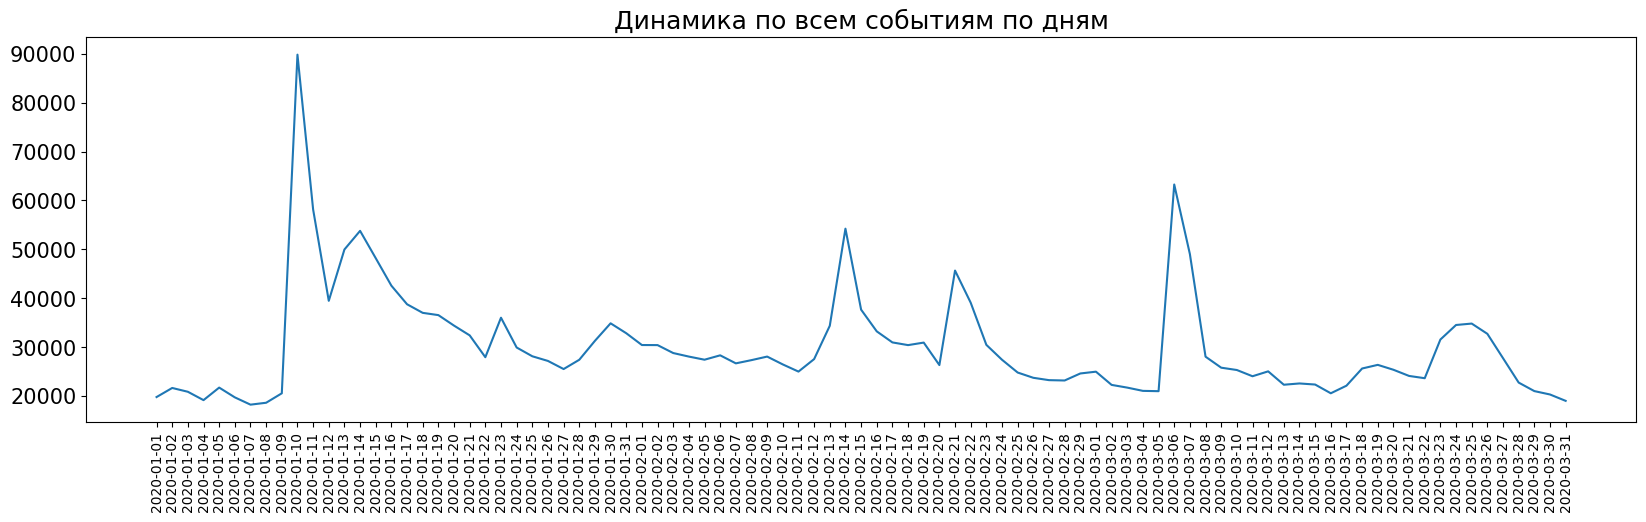

In [85]:
data_events = dt1.groupby('date')['event'].count()
plt.figure(figsize = (20,5))
plt.xticks(rotation=90, fontsize=10)
plt.plot(data_events)
plt.title('Динамика по всем событиям по дням')
plt.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

1. 968 человек, установили приложение 31-ого марта
2. Процентная доля открытий приложения составила 71% на 14 февраля.
3. На графике представлена динамика по всем событиям по дням 

<font size="5" color="yellow"><b>**1.1.3.Выясним в какой день доля трафика от инсталлов была наибольшей**</font>

In [86]:
#Чтобы выполнить данное задание нам нужно воспользоваться уже существующим датафреймом df и создать из него два отдельных датафрейма:
gr1 = dt3[dt3['install_group'] == 'Остальные']
gr2 = dt3[dt3['install_group'] != 'Остальные']

In [87]:
#После этого мы объединяем новые датафреймы по дате:
stat = gr1.merge(gr2, how = 'left', on = 'date')

In [88]:
#Теперь считаем долю трафика от инсталлов/установок по дням и находим, в какой день она наибольшая:
stat['Доля трафика с инсталлов, %'] = stat['users_y']/(stat['users_y'] +stat['users_x'])
stat.sort_values('Доля трафика с инсталлов, %', ascending = False).head()

,date,install_group_x,users_x,install_group_y,users_y,"Доля трафика с инсталлов, %"
0,2020-01-01,Остальные,866,Установили в этот же день,3579,0.805174
1,2020-01-02,Остальные,1957,Установили в этот же день,3144,0.616350
9,2020-01-10,Остальные,8323,Установили в этот же день,13106,0.611601
2,2020-01-03,Остальные,2742,Установили в этот же день,2402,0.466952
13,2020-01-14,Остальные,7764,Установили в этот же день,5173,0.399861


Визуализируем

2020-01-01  - День с максимальной долей трафика от инсталлов


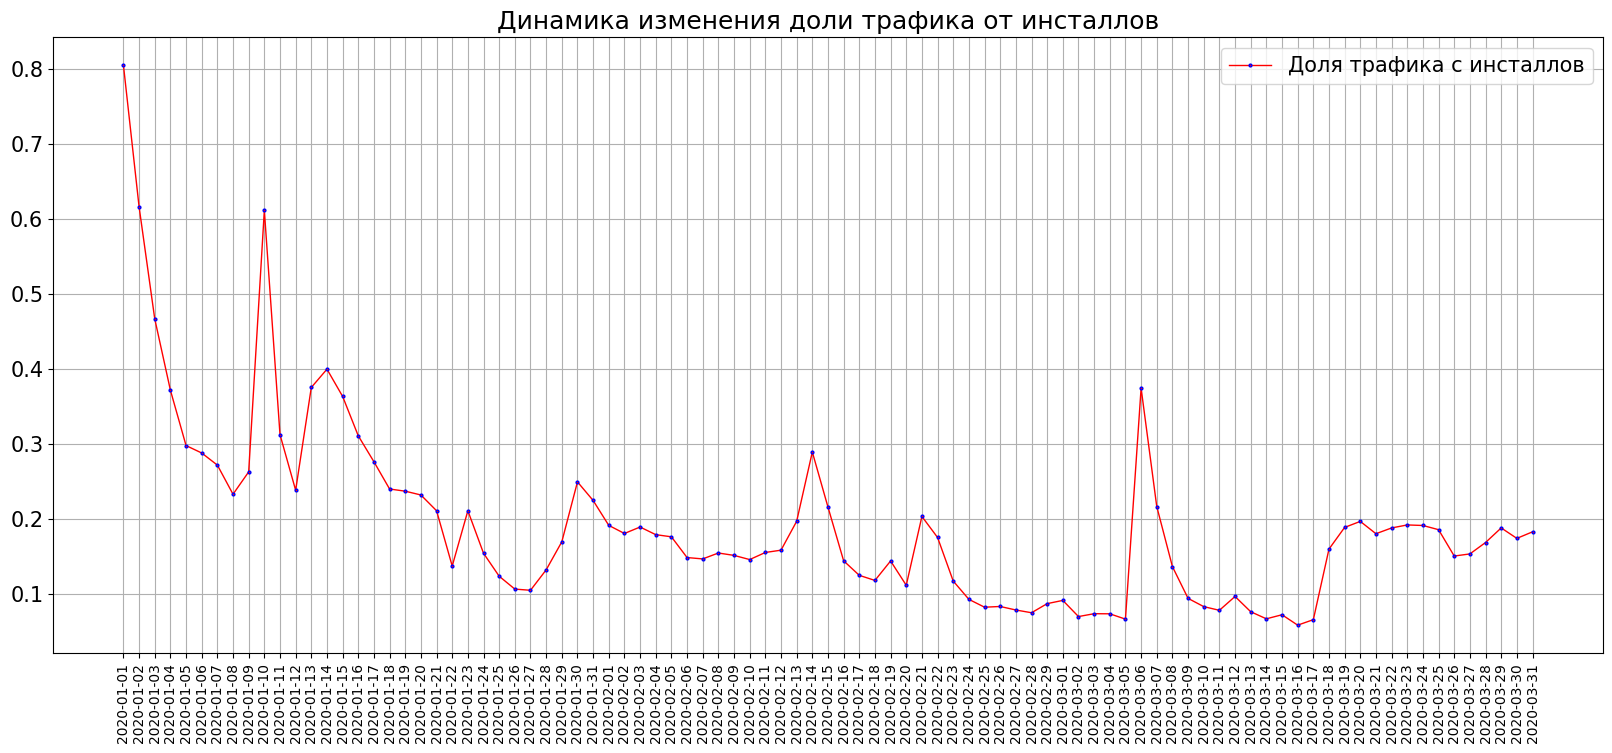

In [89]:
stat['gr'] = 'Трафик с инсталлов'
stat_target_date = stat.sort_values('Доля трафика с инсталлов, %', ascending=False).iloc[0]['date']
x = stat['date']
y1 = stat['Доля трафика с инсталлов, %']
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90, fontsize=10)
plt.plot(x, y1, 'o-r', alpha=1, label="Доля трафика с инсталлов", lw=1, mec='b', mew=1, ms=2)
plt.legend()
plt.title('Динамика изменения доли трафика от инсталлов')
plt.grid(True)
print(stat_target_date, ' - День с максимальной долей трафика от инсталлов')

<font size="5" color="yellow"><b>**Вывод:**</font>

День с максимальной долей трафика от инсталлов 2020-01-01 

<font size="5" color="yellow"><b>**1.1.4.Посмотрим С какого канала (Яндекс, Гугл, ВК, Фейсбук, Инстаграм или Реферальная программа) в Q1 пришло больше всего пользователей (Q1-это первый квартал.)**</font>

1.Найдем с какого канала было больше всего инсталлов?

In [90]:
#Итак, в этом задании нам нужно посчитать количество пользователей, установивших приложение по датам и каналам. 
#Для этого мы выбираем пользователей, которые установили приложение и их группируем:
df_install = dt1[dt1['event'] == 'app_install'].groupby(['date','utm_source']).size().reset_index(name = 'users')

In [91]:
#После этого мы создаем pivot табличку, где считаем суммарное количество пользователей пришедших с разных каналов по дням:
df_install = pd.pivot_table(df_install, values='users', index='utm_source', aggfunc='sum').sort_values('users',ascending = False)

In [92]:
#Смотрим на наш новый датафлем:
df_install.iloc[1:].reset_index()

,utm_source,users
0,yandex-direct,29368
1,google_ads,26286
2,vk_ads,23189
3,instagram_ads,20096
4,facebook_ads,13916
5,referal,9282


2.Найдем  с какого канала было больше всего первых открытий приложения?

In [93]:
#Здесь мы проделываем то же самое. Сначала выбираем пользователей, которые открыли приложение и группируем по дате и каналу, с которого эти пользователи пришли:
df_app_start = dt1[dt1['event'] == 'app_start'].drop_duplicates('device_id').groupby(['date','utm_source']).size().reset_index(name = 'users')

In [94]:
#После этого снова делаем pivot табличку:
df_app_start = pd.pivot_table(df_app_start, values='users', index='utm_source', aggfunc='sum').sort_values('users',ascending = False)

In [95]:
#Смотрим, что получилось:
df_app_start.iloc[1:].reset_index()

,utm_source,users
0,yandex-direct,34441
1,google_ads,31437
2,vk_ads,27905
3,instagram_ads,24818
4,facebook_ads,18844
5,referal,11983


3.Строим график

In [96]:
df =dt1[dt1['event'] == 'app_install'].groupby(['date','utm_source']).size().reset_index(name = 'users')
# Группировка данных
grouped_data = df.pivot(index='date', columns='utm_source', values='users')
# Построение интерактивного графика
fig = px.line(grouped_data, x=grouped_data.index, y=grouped_data.columns)
# Настройка осей и заголовка
fig.update_layout(
    xaxis_title='Дата',
    yaxis_title='Количество пользователей',
    title='Динамика установок приложения по каналам привлечения'
)
# Отображение легенды
fig.update_traces(showlegend=True)
# Отображение графика
fig.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

1.Больше всего инсталов было из канала "ЯНДЕКС"

2.Наибольшее количество первых открытий было сделано тоже из канала "Яндекс"

взлянув на график можно наглядоно увидеть, что лидиром я вляется ЯНДЕКС.

<font size="5" color="yellow"><b>**1.1.5.Проанализируем, на каком этапе воронки отваливается большая часть клиентов. Посмотрим отдельно сценарии для зарегистрированных и для незарегистрированных пользователей т.е. посчитаем конверсионные показатели на всех этапах отдельно для зарегистрированных пользователей и незарегистрированных.**</font>

1.Выясним, на каком шаге отваливается больше всего зарегистрированных пользователей

In [97]:
#Находим пользователей, которые зарегистрированы и добавляем новый столбец с 1, что означает, что они зарегистрированы:
first_registration = dt1[dt1['event'] == 'register'].sort_values('date').drop_duplicates('device_id')
first_registration['finally_registered'] = 1

In [98]:
# Добавляем столбец с датой регистрации в табличку data и добавляем еще один столбец 'finally_registered' с значением 1, который обозначает, что регистрация была 
# Для этого используем функцию map:
dt1['first_registration'] = dt1['device_id'].map(first_registration.set_index('device_id')['date'])
dt1['finally_registered'] = dt1['device_id'].map(first_registration.set_index('device_id')['finally_registered'])

In [ ]:
#После этого мы сравниваем дату 'first_registration' с 'date', и обозначаем зарегистрированных пользователей 1, а незарегистрированных 0:
already_reg = dt1[dt1['first_registration'] < dt1['date']]
already_reg['registered'] = 1
requires_reg1 = dt1[(dt1['first_registration'].isna() == True)]
requires_reg1['registered'] = 0
requires_reg2 =  dt1[dt1['first_registration'] >= dt1['date']]
requires_reg2['registered'] = 0

In [100]:
#Далее мы объединяем полученные в табличку data и выбираем тех, кто дошли до покупки:
data = pd.concat([already_reg,requires_reg1,requires_reg2])

In [101]:
#После этого подсчитываем зарегистрированных и незарегистрированных пользователей на всех этапах:
data[data['event'] == 'tap_basket'].groupby('registered').count()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,install_group,first_registration,finally_registered
registered,,,,,,,,,,,,
0,160409,160409,0,160409,160409,160409,160409,160409,130022,160409,105031,105031
1,217256,217256,0,217256,217256,217256,217256,217256,177108,217256,217256,217256


In [102]:
#Теперь, чтобы подготовить финальную табличку с количеством пользователей на разных этапах для расчета конверсии зарегистрированных пользователей, 
# создаем новую таблицу, выбираем только зарегистрированных(1) и с помощью функции crosstab делаем объединение таблиц.
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)

In [103]:
#Теперь рассчитываем конверсию на каждом этапе для зарегестрированных пользователей:
funnel_reg['1 step'] = funnel_reg['search']*100/funnel_reg['app_start']
funnel_reg['2 step'] = funnel_reg['choose_item']*100/funnel_reg['search']
funnel_reg['3 step'] = funnel_reg['tap_basket']*100/funnel_reg['choose_item']
funnel_reg['5 step'] = funnel_reg['purchase']*100/funnel_reg['tap_basket']
funnel_reg

event,app_start,choose_item,purchase,search,tap_basket,1 step,2 step,3 step,5 step
utm_source,,,,,,,,,
-,9482,8728,5492,9355,7850,98.660620,93.297702,89.940422,69.961783
facebook_ads,5606,5154,3333,5527,4694,98.590796,93.251312,91.074893,71.005539
google_ads,5399,4948,3121,5335,4438,98.814595,92.746017,89.692805,70.324470
instagram_ads,5686,5288,3548,5618,4842,98.804080,94.126023,91.565809,73.275506
referal,3647,3417,2382,3610,3155,98.985468,94.653740,92.332455,75.499208
vk_ads,6011,5636,3950,5958,5196,99.118283,94.595502,92.193045,76.020015
yandex-direct,5396,4928,3099,5304,4464,98.295033,92.911011,90.584416,69.422043


In [104]:
#Упростим датафрейм для наглядности:
reg = funnel_reg.sum().iloc[5:]
reg


event
1 step    691.268875
2 step    655.581306
3 step    637.383845
5 step    505.508565
dtype: float64

2.Выясним, на каком шаге отваливается больше всего незарегистрированных пользователей

In [105]:
#Точно так же подготавливаем таблицу с количеством пользователей на разных этапах для расчета конверсии но тольно для незарегистрированных пользователей, 
# создаем новую таблицу, выбираем только незарегистрированных(0) и с помощью функции crosstab делаем объединение таблиц.
not_reg = data[data['registered'] == 0]
funnel_not_reg = pd.crosstab(not_reg.utm_source, not_reg.event, values=not_reg.device_id, aggfunc=pd.Series.nunique)

In [106]:
#Рассчитываем конверсию на каждом этапе для незарегестрированных пользователей:
funnel_not_reg['1 step'] = funnel_not_reg['search']*100/funnel_not_reg['app_start']
funnel_not_reg['2 step'] = funnel_not_reg['choose_item']*100/funnel_not_reg['search']
funnel_not_reg['3 step'] = funnel_not_reg['tap_basket']*100/funnel_not_reg['choose_item']
funnel_not_reg['4 step'] = funnel_not_reg['register']*100/funnel_not_reg['tap_basket']
funnel_not_reg['5 step'] = funnel_not_reg['purchase']*100/funnel_not_reg['register']
funnel_not_reg

event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 step,2 step,3 step,4 step,5 step
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.038627,81.352959,76.850050,56.554769,85.151570
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.971405,81.995443,77.977876,59.429825,86.554428
google_ads,26286,35778,27416,9777,11405,34217,20765,95.636984,80.123915,75.740444,54.924151,85.725559
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.827205,81.586180,78.226442,60.119680,87.386047
referal,9282,14866,11880,5503,6193,14316,9518,96.300283,82.984074,80.117845,65.066190,88.858389
vk_ads,23189,32353,25422,10919,12421,31010,20014,95.848917,81.980006,78.727087,62.061557,87.907576
yandex-direct,29368,38578,29591,10581,12342,36933,22417,95.735912,80.120759,75.756142,55.056430,85.731648


In [107]:
#Упростим датафрейм для наглядности:
not_reg = funnel_not_reg.sum().iloc[7:]
not_reg

event
1 step    671.359332
2 step    570.143336
3 step    543.395885
4 step    413.212602
5 step    607.315216
dtype: float64

3.Строим графики

<Figure size 640x480 with 0 Axes>

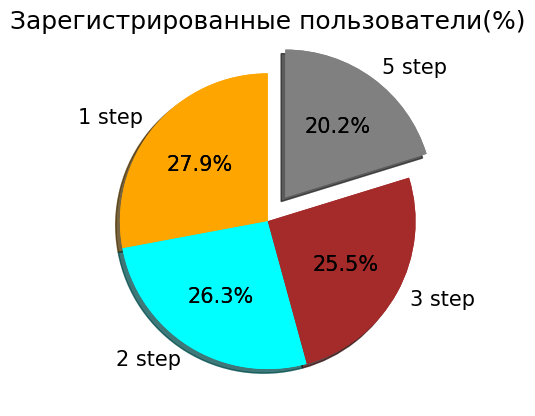

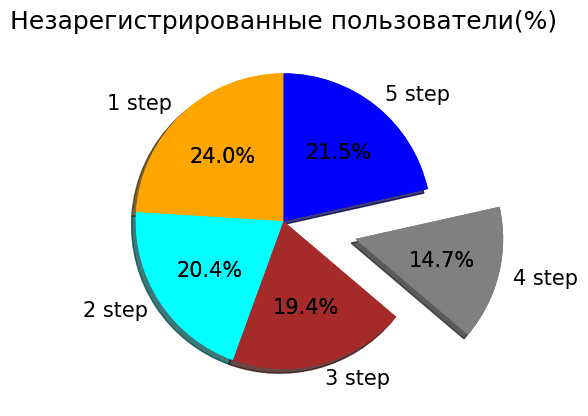

In [108]:
plt.figure(0)
labels = '1 step', '2 step', '3 step', '5 step'
sizes = [69, 65, 63, 50]

colors = ( "orange", "cyan", "brown", 
          "grey", "blue") 
fig1, ax1 = plt.subplots()

explode = (0, 0, 0, 0.2) 
plt.title('Зарегистрированныe пользователи(%)')
ax1.pie(sizes, colors = colors, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=90)
patches, texts, auto = ax1.pie(sizes, colors=colors, shadow=True, startangle=90,explode=explode, autopct='%1.1f%%' )


plt.figure(1)
labels = '1 step', '2 step', '3 step', '4 step', '5 step'
sizes = [67, 57, 54, 41, 60 ]

colors = ( "orange", "cyan", "brown", 
          "grey", "blue") 
fig1, ax1 = plt.subplots()

explode = (0, 0, 0, 0.5, 0) 
plt.title('Незарегистрированныe пользователи(%)')
ax1.pie(sizes, colors = colors, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=90)
patches, texts, auto = ax1.pie(sizes, colors=colors, shadow=True, startangle=90,explode=explode, autopct='%1.1f%%' )


plt.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

1.На 5-ом шаге 'ПОКУПКА' - 5 step больше всего произошел отток зарегистрированных пользователей.

2.На 4-ом шаге 'РЕГИСТРАЦИЯ' - 4 step больше всего произошел отток незарегистрированных пользователей.

<font size="5" color="yellow"><b>**1.1.6.Найдем количество пользователей, пришедших из различных каналов, посмотрим на показатели (за весь Q1 период), определим  самую высокую и самую низкую конверсию в первую покупку(Q1-это первый квартал.)**</font>

In [109]:
#Сформируем две новые таблицы по событиям от открытия приложения до потверждения покупки, отсортируемся по дате и сгруппируемся по каналам откуда пришли пользователи:
first_opens = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
first_purchase = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
#Соединим таблицы  и подсчитаем конверсию 
stat = first_opens.merge(first_purchase, how = 'left', on = 'utm_source')
stat['CR to first purchase'] = stat['users_y']/stat['users_x']
stat.iloc[1:]

,utm_source,users_x,users_y,CR to first purchase
1,facebook_ads,18844,7903,0.419391
2,google_ads,31437,10167,0.323409
3,instagram_ads,24818,9820,0.395681
4,referal,11983,5803,0.484269
5,vk_ads,27905,11460,0.410679
6,yandex-direct,34441,10936,0.317529


Визуализируем данные

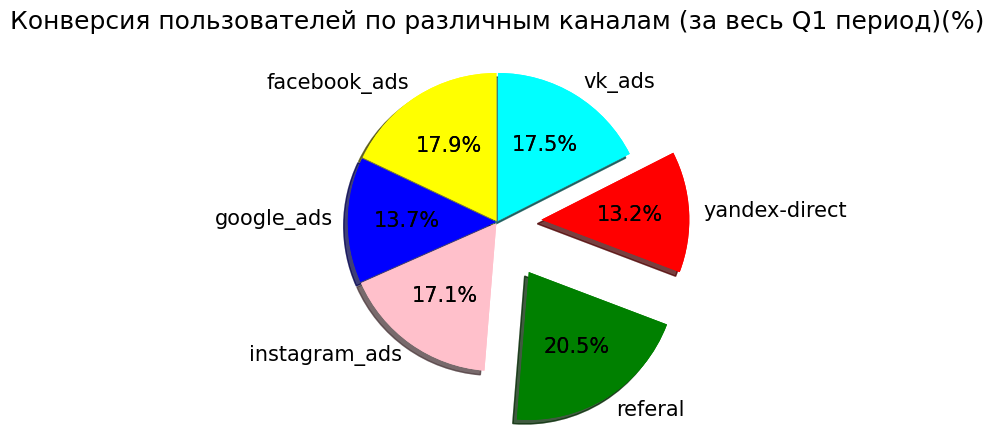

In [110]:
labels = 'facebook_ads', 'google_ads', 'instagram_ads', 'referal', 'yandex-direct','vk_ads'
sizes = [42, 32, 40, 48, 31, 41 ]

colors = ( "yellow", "blue", "pink", 
          "green", "red", "cyan") 
fig1, ax1 = plt.subplots()

explode = (0.01, 0.01, 0.01, 0.4, 0.3, 0.01) 
plt.title('Конверсия пользователей по различным каналам (за весь Q1 период)(%)')
ax1.pie(sizes, colors = colors, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
patches, texts, auto = ax1.pie(sizes, colors=colors, shadow=True, startangle=90,explode=explode, autopct='%1.1f%%' )



<font size="5" color="yellow"><b>**Вывод:**</font>

На графике отчетливо можно увидеть, что Самый большой CR(коофициент конверсии) — у реферальной программы(referal), а самый маленький — у Яндекс.Директа(yandex-direct).

<font size="5" color="yellow"><b>**1.1.7.Найдем канал из которого пришли пользователи с наивысшим медианным чеком (Учитываются только первые покупки пользователей.)**</font>

In [111]:
#Сформируем таблицу по событиям от открытия приложения до потверждения покупки, отсортируемся по дате и сгруппируемся по каналам откуда пришли пользователи
#найдем стоимость покупки (при совершении события ‘purchase’) и выявим канал с максимальной медианой первой покупки:
first_purch_medin = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby('utm_source')\
['purchase_sum'].agg(['median']).iloc[1:].reset_index()
#Смотрим, что получилось
first_purch_medin

,utm_source,median
0,facebook_ads,389.0
1,google_ads,390.5
2,instagram_ads,393.5
3,referal,395.5
4,vk_ads,393.0
5,yandex-direct,392.5


In [112]:
#Выделим максимальный канал
first_purch_medin[first_purch_medin['median'] == first_purch_medin['median'].max()]

,utm_source,median
3,referal,395.5


Визуализируем 

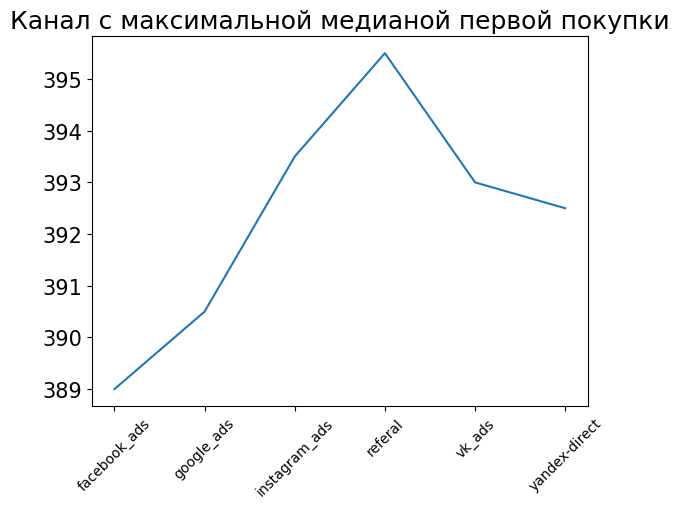

In [113]:
plt.plot(first_purch_medin['utm_source'], first_purch_medin['median'])
plt.xticks(rotation=45, fontsize=10)
plt.title('Канал с максимальной медианой первой покупки')
plt.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

Канал с наивысшим медианным чеком является - Реферальная программа(referal)

<font size="5" color="yellow"><b>**1.1.8.Подсчитаем ROMI для каждого канала, выявим самый низкий и самый высокий показатель в %.**</font>

*ROMI – это показатель рентабельности рекламных кампаний и в целом инвестиций в маркетинговую деятельность. Рентабельность оперирует такими метриками как окупаемость, прибыль, возврат вложений. Как и в случае с ROI, ROMI помогает быстро оценить эффективность проводимых мероприятий, без учета различных погрешностей – бухгалтерские расходы, сезонность спроса и других.*

In [114]:
#Первым делом отфильтруем наш датафрейм по событию покупки:
data_purchase = data.loc[data['event'] == 'purchase']

In [115]:
#Далее группируем наши данные по каналам привлечения и считаем сумму покупок по каждому каналу:
data_purchase_sum = data_purchase.groupby('utm_source')['purchase_sum'].sum().reset_index().iloc[1:]

In [116]:
#Смотрим на полученный датафрейм:
data_purchase_sum

,utm_source,purchase_sum
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


In [117]:
#Чтобы найти ROMI, необходимо разделить наши полученные доходы на затраты на рекламу (которые даны в задании) и умножить  на 100.
print('Яндекс: {} %'.format((13915368/10491707 -1)*100))
print('Гугл: {} %'.format((12868276/10534878-1)*100))
print('Фейсбук: {} %'.format((12249901/8590498-1)*100))
print('Инстаграм: {} %'.format((14546969/8561626  -1)*100))
print('ВК: {} %'.format((16389653/9553531-1)*100))

Яндекс: 32.63206835646477 %
Гугл: 22.149264566708805 %
Фейсбук: 42.59826380263403 %
Инстаграм: 69.90895187432855 %
ВК: 71.5559723415353 %


Визуализируем

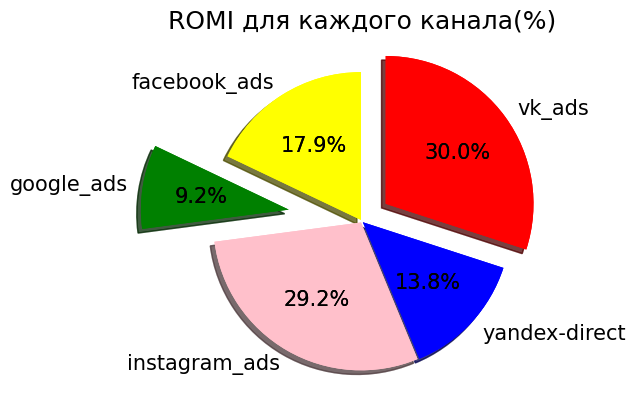

In [118]:
labels = 'facebook_ads', 'google_ads', 'instagram_ads', 'yandex-direct','vk_ads'
sizes = [43, 22, 70, 33, 72 ]

colors = ( "yellow", "green", "pink", 
          "blue", "red") 
fig1, ax1 = plt.subplots()

explode = (0.01, 0.5, 0.01, 0.01, 0.2) 
plt.title('ROMI для каждого канала(%)')
ax1.pie(sizes, colors = colors, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
patches, texts, auto = ax1.pie(sizes, colors=colors, shadow=True, startangle=90,explode=explode, autopct='%1.1f%%' )

<font size="5" color="yellow"><b>**Вывод:**</font>

Самый высокий ROMI — у ВК (71 %), а самый низкий - у Гугл (22%)

<font size="5" color="red"><b>**Проведем когортный анализ по: неделе первого посещения, неделе регистрации, неделе первой покупки**</font>

<font size="5" color="yellow"><b>**1.2.1.Выявим какая когорта самая активная?**</font>

In [119]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,install_group,first_registration,finally_registered,registered
15148,2020-01-02,app_start,NaN,ios,3163406,female,Moscow,instagram_ads,2020-01-01,Остальные,2020-01-01,1.0,1
15175,2020-01-02,app_start,NaN,ios,2169108,female,Moscow,google_ads,2020-01-01,Остальные,2020-01-01,1.0,1
15197,2020-01-02,app_start,NaN,android,4863305,male,Saint-Petersburg,vk_ads,2020-01-01,Остальные,2020-01-01,1.0,1
15210,2020-01-02,app_start,NaN,android,15248490,male,Moscow,facebook_ads,2020-01-01,Остальные,2020-01-01,1.0,1
15214,2020-01-02,app_start,NaN,ios,25617659,male,Moscow,vk_ads,2020-01-01,Остальные,2020-01-01,1.0,1


In [122]:
## Создаём переменную с данными пользователей, сделавших покупки и избавляемся от дубликатов по device_id:
entrances = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id')
data['first_entrance'] = data['device_id'].map(entrances.set_index('device_id')['date'])
data['first_entrance'] = pd.to_datetime(data['first_entrance'], format = '%Y-%m-%d')
data['first_entrance_cohort'] = data['first_entrance'].apply(lambda x: x + dt.timedelta(days=-x.weekday(), weeks=0))
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['n_week'] = data['date'] - data['first_entrance_cohort']
data['n_week'] = data['n_week'].apply(lambda x: x.days // 7 )
data['first_entrance_cohort'] = data['first_entrance_cohort'].apply(lambda x: str(x)[:10])

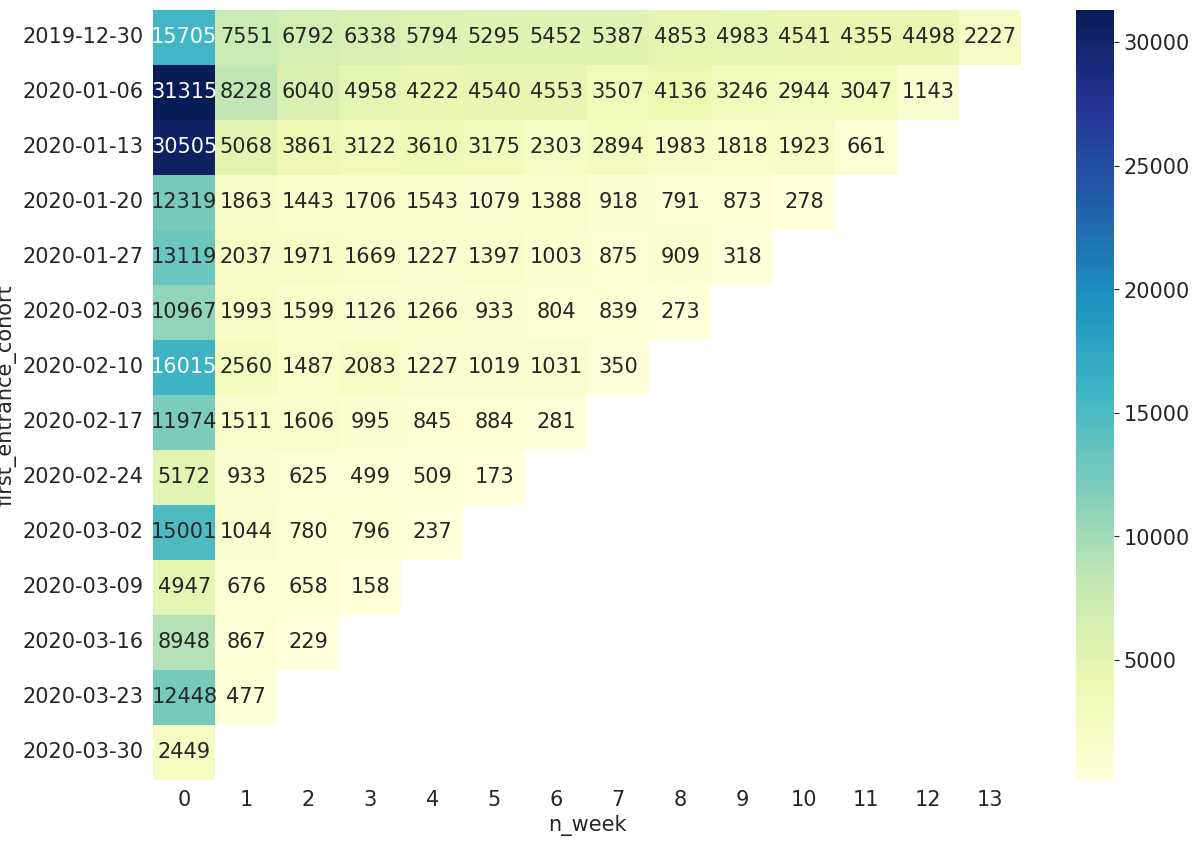

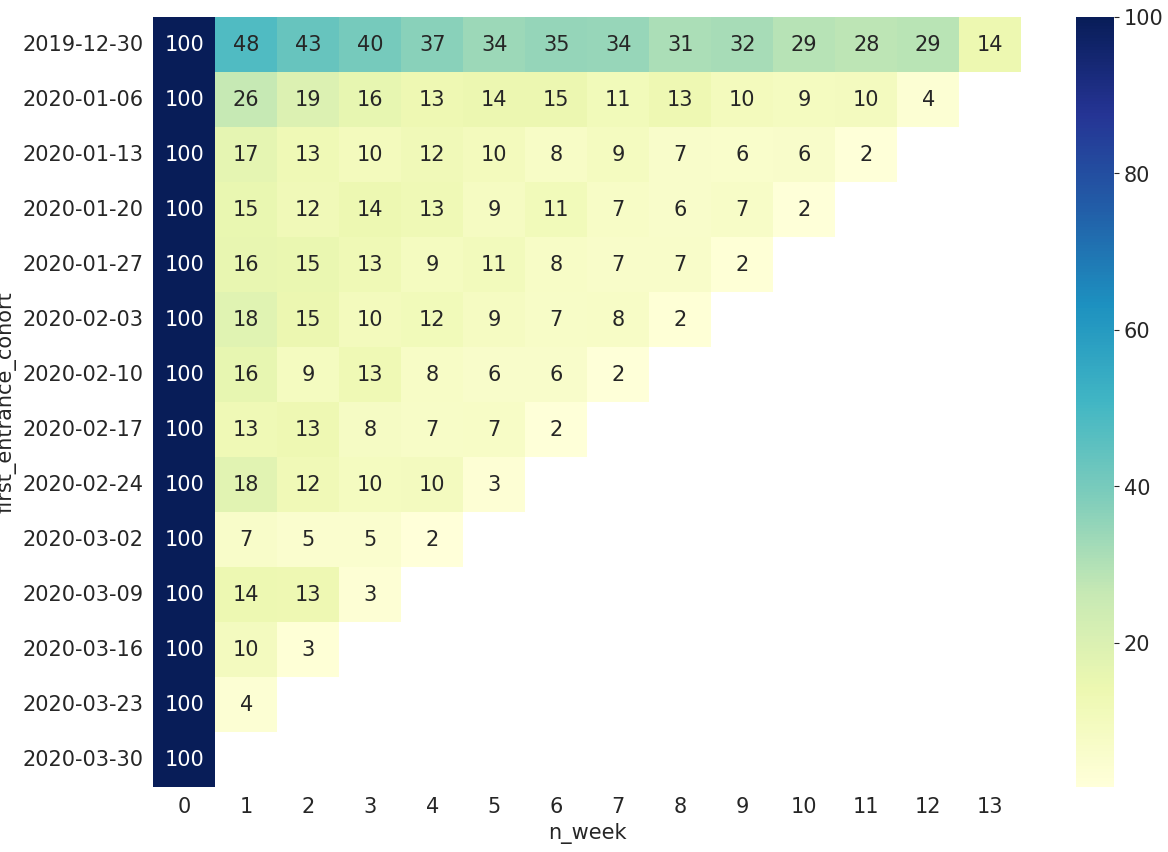

In [123]:
#визуализируем и выявляем самую активную когорту 
viz = data.pivot_table(
                        index='first_entrance_cohort', 
                        columns='n_week', 
                        values='device_id', 
                        aggfunc=pd.Series.nunique)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");
    
viz = viz.apply(lambda x: x*100/viz[0])
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

<font size="5" color="yellow"><b>**Вывод:**</font>

Самая активная когорта — когорта, пришедшая на первой неделе -30.12.2019. Активность этой когорты в несколько раз выше, чем у остальных. 

Эта же когорта приносит больше всего денег. Стоит стремиться к тому, чтобы все остальные когорты были похожи на неё. Особенно это заметно по второму графику в процентных значениях.

<font size="5" color="yellow"><b>**1.2.2.Преверим регистрируются ли все пользователи в день первого посещения**</font>

In [ ]:
# Создаём новый датафрейм с данными пользователей, имеющих не пустые значения даты первой покупки:
df = data[-data['first_registration'].isna()]
df['first_registration'] = pd.to_datetime(df['first_registration'], format = '%Y-%m-%d')
df['first_registration_cohort'] = df['first_registration'].apply(lambda x: x + dt.timedelta(days=-x.weekday(), weeks=0))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['n_week'] = df['date'] - df['first_registration_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['first_registration_cohort'] = df['first_registration_cohort'].apply(lambda x: str(x)[:10])

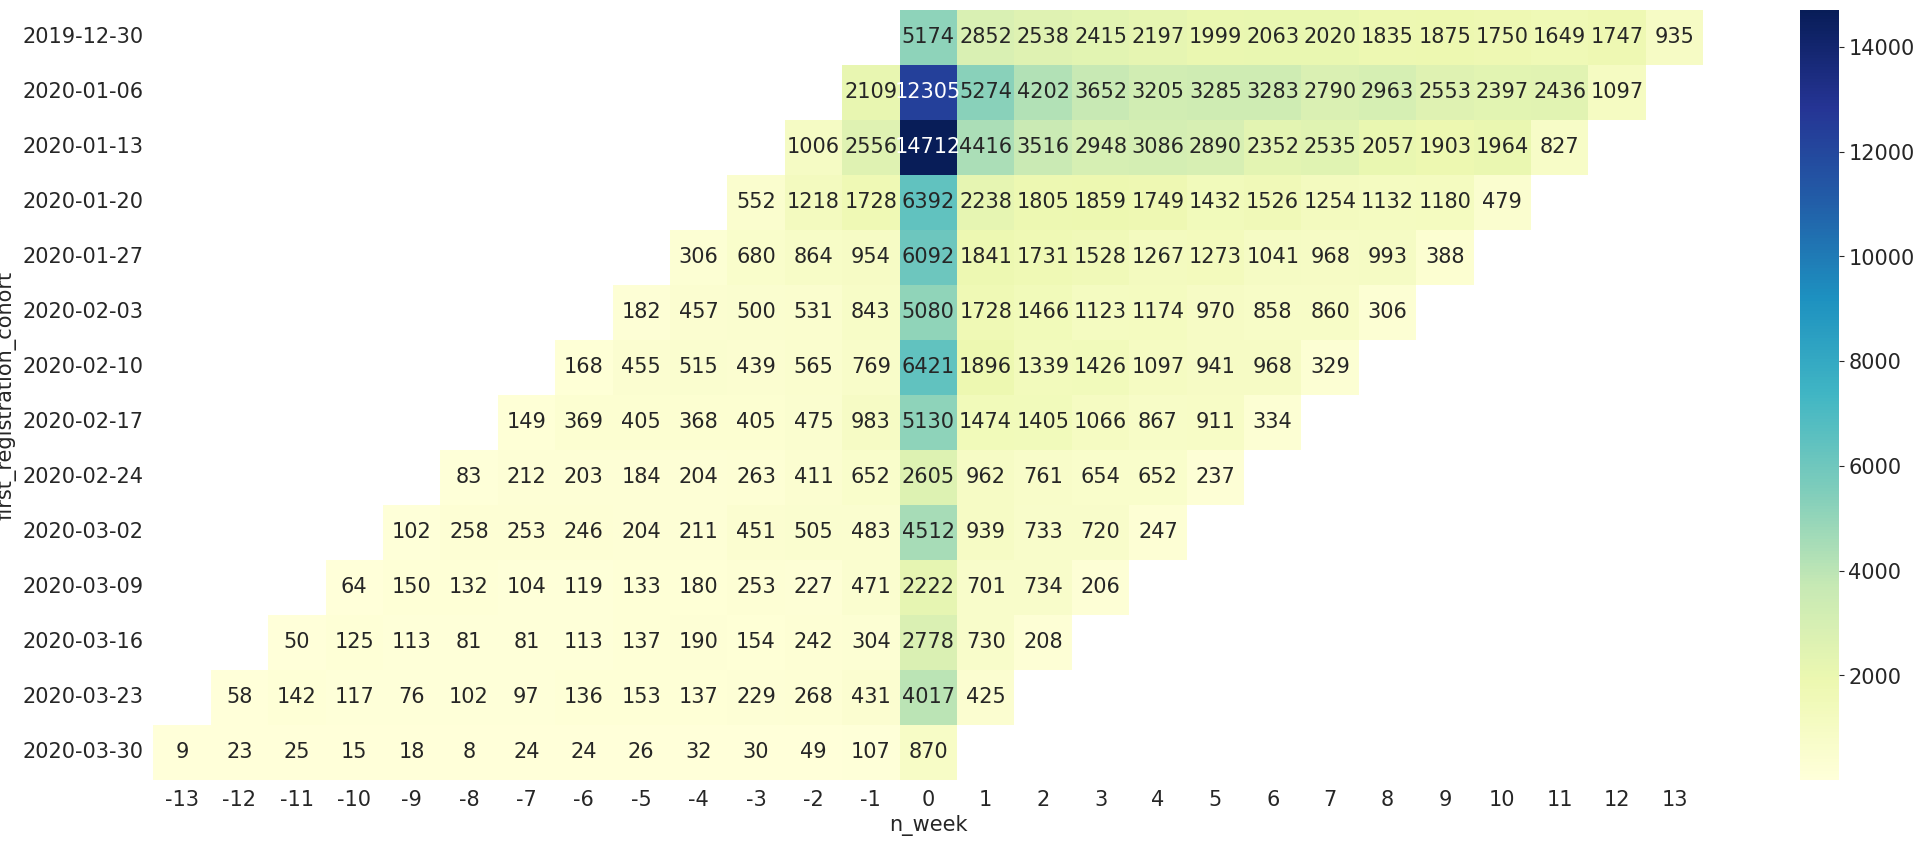

In [125]:
#Визуализируем
viz = df.pivot_table(
                        index='first_registration_cohort', 
                        columns='n_week', 
                        values='device_id', 
                        aggfunc=pd.Series.nunique)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

<font size="5" color="yellow"><b>**Вывод:**</font>


График показывает нам, что многие пользователи несколько недель подряд заходят в приложение, прежде чем зарегистрироваться.

<font size="5" color="yellow"><b>**1.2.3.Определим какая когорта принесла больше всего денег**</font>

In [126]:
# Создаём переменную с данными пользователей, сделавших покупки и избавляемся от дубликатов по device_id:
purchases = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
# Добавляем столбец с данными первой покупки:
data['first_purchase'] = data['device_id'].map(purchases.set_index('device_id')['date'])
# Добавляем столбец с временем первой покупки:
data['first_purchase'] = pd.to_datetime(data['first_purchase'], format = '%Y-%m-%d')


In [ ]:
# Создаём новый датафрейм с данными пользователей, имеющих не пустые значения даты первой покупки:
df = data[-data['first_purchase'].isna()]
df['first_purchase_cohort'] = df['first_purchase'].apply(lambda x: x + dt.timedelta(days=-x.weekday(), weeks=0))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['n_week'] = df['date'] - df['first_purchase_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['first_purchase_cohort'] = df['first_purchase_cohort'].apply(lambda x: str(x)[:10])
df = df[df['event'] == 'purchase']
df1 = df.groupby('first_purchase_cohort')['purchase_sum'].sum().reset_index(name = 'LTV').sort_values('LTV', ascending = False)
df1

In [128]:
#Выделим максимальную когорту в какой день она принесла больше всего денег
df1[df1['LTV'] == df1['LTV'].max()]

,first_purchase_cohort,LTV
1,2020-01-06,19787838.0


Визуализируем

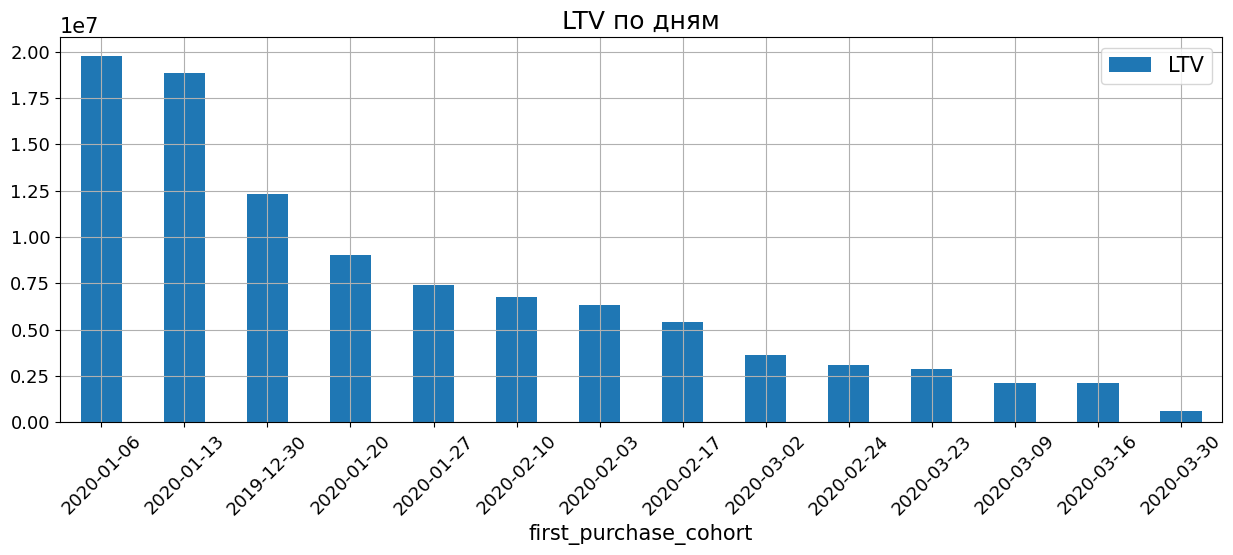

In [129]:
#dt2 = dt2.iloc[9:65]
plt.rcParams['font.size'] = '15'
df1.plot(
    kind='bar',
    grid=True,
    figsize=(15, 5),
    x='first_purchase_cohort',
    y= 'LTV',
    rot=45,
    fontsize=13,
    title='LTV по дням'

 )
plt.show()

<font size="5" color="yellow"><b>**Вывод:**</font>

На графике отчетливо видно, что когорта 06.01.2020 заняла строчку лидера, она принесла наибольшее количество денег (19787838 руб.)

<font size="5" color="yellow"><b>**1.2.4.Определим у какой когорты выше медианный чек на неделе первой покупки**</font>

In [130]:
# Создаём переменную с данными пользователей, сделавших покупки и избавляемся от дубликатов по device_id:
purchases = data[data.event == 'purchase'].sort_values('date').drop_duplicates('device_id')
# Добавляем столбец с данными первой покупки:
data['first_purchase'] = data['device_id'].map(purchases.set_index('device_id')['date'])
# Добавляем столбец с временем первой покупки:
data['first_purchase'] = pd.to_datetime(data['first_purchase'], format = '%Y-%m-%d')

In [ ]:
# Создаём новый датафрейм с данными пользователей, имеющих не пустые значения даты первой покупки:
top_cohort = data[-data['first_purchase'].isna()]
top_cohort['first_purchase_cohort'] = top_cohort['first_purchase'].apply(lambda x: x + dt.timedelta(days = -x.weekday(), weeks = 0))
top_cohort['date'] = pd.to_datetime(top_cohort['date'], format = '%Y-%m-%d')
top_cohort['n_week'] = top_cohort['date'] - top_cohort['first_purchase_cohort']
top_cohort['n_week'] = top_cohort['n_week'].apply(lambda x: x.days // 7)
top_cohort['first_purchase_cohort'] = top_cohort['first_purchase_cohort'].apply(lambda x: str(x)[:10])
top_cohort = top_cohort[top_cohort['event'] == 'purchase']
top_cohort.groupby('first_purchase_cohort')['purchase_sum'].sum().reset_index(name = 'LTV').sort_values('LTV', ascending = False)

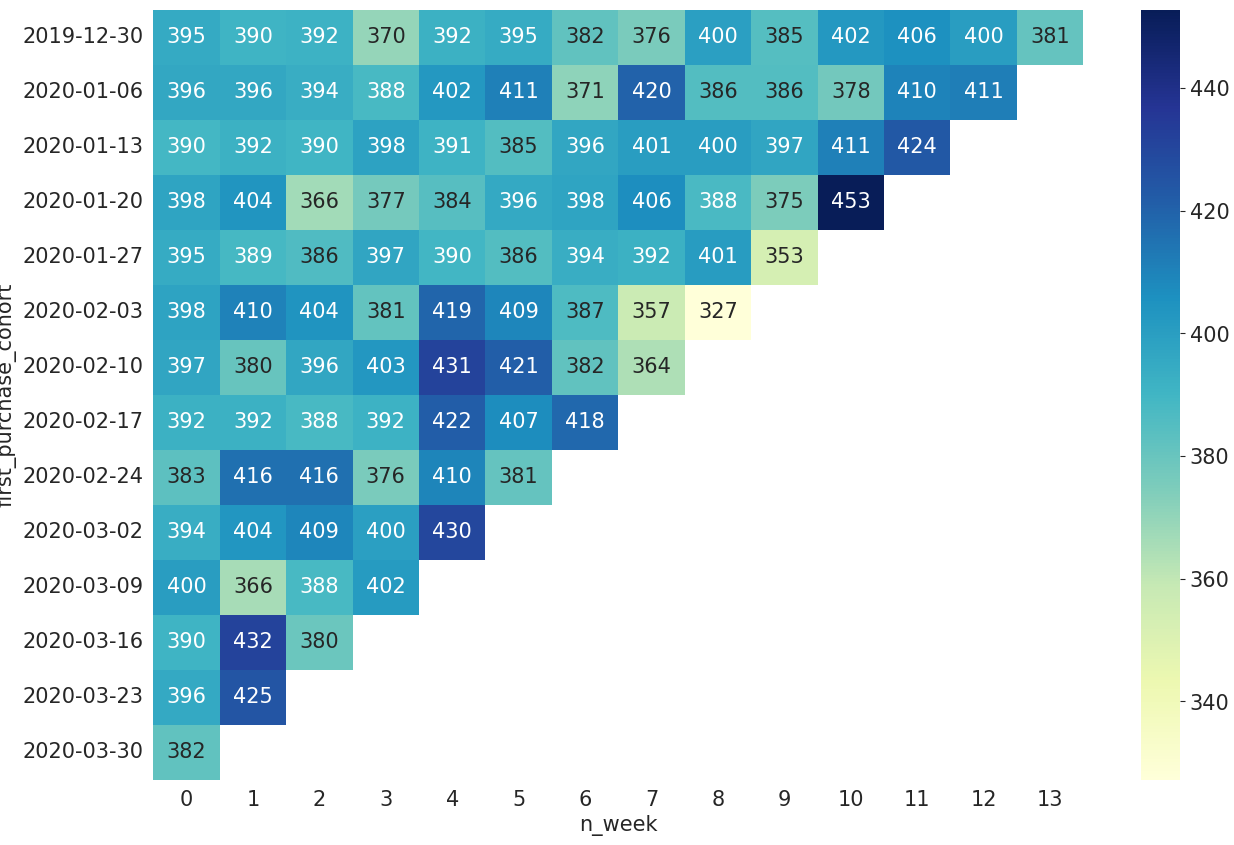

In [132]:
# Визуализируем динамику по неделе первой покупки, выбор самой активной когорты и анализ динамики активности. Используем датафрейм top_cohort:
viz = top_cohort.pivot_table(
                        index='first_purchase_cohort', 
                        columns='n_week', 
                        values='purchase_sum', 
                        aggfunc=np.median)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu")

<font size="5" color="yellow"><b>**Вывод:**</font>

Медианный чек на неделе первой покупки выше у когорты от 9 марта(09.03.2020) (400 рублей).

<font size="5" color="yellow"><b>**1.2.5.Сравним медианный чек на второй неделе с момента первой покупки для всех каналов привлечения**</font>

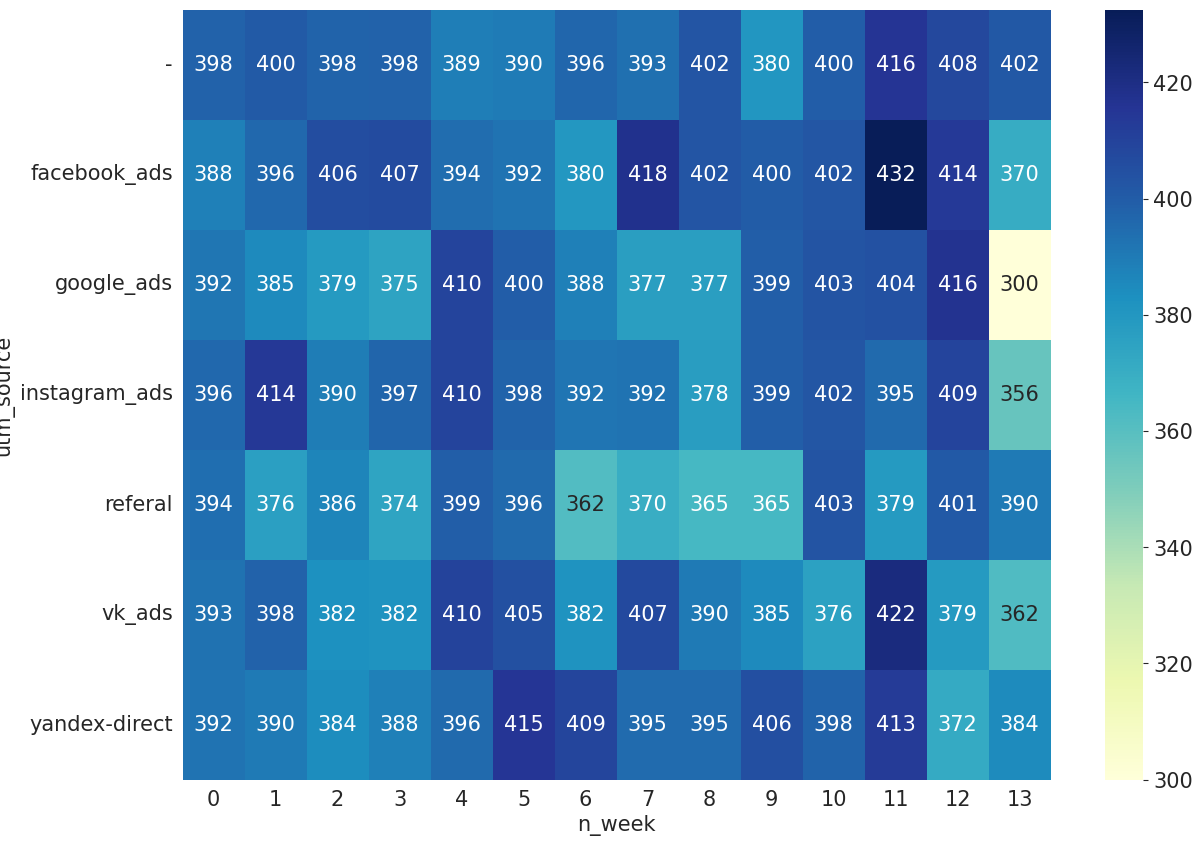

In [133]:
#строим график т.к. все данные уже имеются
viz = df.pivot_table(
                        index='utm_source', 
                        columns='n_week', 
                        values='purchase_sum', 
                        aggfunc=np.median)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

<font size="5" color="yellow"><b>**Вывод:**</font>

При сравнении медианного чека на второй недели с момента первой покупки, лидирующуу строчку занял Инстаграмм его медианный чек = 414 руб. Самый низкий показатель у  Реферальной программы, его медианный чек составил =376 руб.